In [2]:
# https://platform.openai.com/docs/guides/vision
from openai import OpenAI
import base64
import requests
import os
from PIL import Image
from pillow_heif import register_heif_opener
import torch
from transformers.image_utils import ImageFeatureExtractionMixin
from scipy.spatial.transform import Rotation as R
import open3d as o3d
import numpy as np
import pyrealsense2 as rs
import matplotlib.pyplot as plt
from magpie import realsense_wrapper as real

# Initialize RS435i connection
rsc = real.RealSense()
rsc.initConnection()


In [3]:
# Import OWL-ViT
# from LANGrasp: https://huggingface.co/docs/transformers/model_doc/owlvit
from transformers import OwlViTProcessor, OwlViTForObjectDetection
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")

In [4]:
# Import Segment Anything
from segment_anything import build_sam, SamPredictor 
import cv2
import copy

predictor = SamPredictor(build_sam(checkpoint="/home/will/workspace/owlvit_segment_anything/sam_vit_h_4b8939.pth"))

In [5]:
# Helper Functions

# plot predictions
# https://github.com/huggingface/notebooks/blob/main/examples/zeroshot_object_detection_with_owlvit.ipynb
SCORE_THRESHOLD = 0.01

def get_boxes(input_image, text_queries, scores, boxes, labels, score_threshold=SCORE_THRESHOLD):
    pboxes = []
    uboxes = []
    for score, box, label in zip(scores, boxes, labels):
      if score < score_threshold:
        continue
      cx, cy, w, h = box
      x0 = (cx - w/2) * 1280
      y0 = (cy - h/2) * 720
      x1 = (cx + w/2) * 1280
      y1 = (cy + h/2) * 720
      pbox = [x0, y0, x1, y1]
      pboxes.append((pbox, text_queries[label]))
      uboxes.append((box, text_queries[label]))
    return pboxes, uboxes

def plot_predictions(input_image, text_queries, scores, boxes, labels, score_threshold=SCORE_THRESHOLD):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(input_image, extent=(0, 1, 1, 0))
    ax.set_axis_off()
    
    idx = 0
    for score, box, label in zip(scores, boxes, labels):
      if score < score_threshold:
        continue
      cx, cy, w, h = box
      x0 = (cx - w/2) * 1280
      y0 = (cy - h/2) * 720
      x1 = (cx + w/2) * 1280
      y1 = (cy + h/2) * 720
      pbox = [x0, y0, x1, y1]
      print(pbox)
      ax.plot([cx-w/2, cx+w/2, cx+w/2, cx-w/2, cx-w/2],
              [cy-h/2, cy-h/2, cy+h/2, cy+h/2, cy-h/2], "r")
      ax.text(
          cx - w / 2,
          cy + h / 2 + 0.015,
          f"{text_queries[label]} ({idx}): {score:1.2f}",
          ha="left",
          va="top",
          color="red",
          bbox={
              "facecolor": "white",
              "edgecolor": "red",
              "boxstyle": "square,pad=.3"
          })
      idx += 1

def show_mask(mask, ax, random_color=False):
    '''
    @param mask bool image mask
    @param ax matplotlib fig
    '''
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def encode_image(image_path):
    with open(f"{image_path}", "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')
    
def displayWorld(worldPCD):
    coordFrame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.05)
    geometry = [coordFrame]
    geometry.append(worldPCD)
    o3d.visualization.draw_geometries(geometry)

In [6]:
def retrieve_mask_from_image_crop(box, full_o3d_image):
    '''
    @param box 2d bounding box in form [x0, y0, x1, y1]
    @param full_o3d_image Open3D RGBD Image
    '''
    x_min = int(box[0])
    y_min = int(box[1])
    x_max = int(box[2])
    y_max = int(box[3])
    # y_min = int(box[0])
    # x_min = int(box[1])
    # y_max = int(box[2])
    # x_max = int(box[3])
    x_center = (x_min + x_max) / 2
    y_center = (y_min + y_max) / 2
    bbox = x_min, y_min, x_max, y_max

    # mask out bounding box in img
    depth_image = np.asarray(full_o3d_image.depth)
    # depth_values = depth_image[x_min:x_max, y_min:y_max]
    depth_values = depth_image[y_min:y_max, x_min:x_max]
    depth_o3d = o3d.geometry.Image((depth_values).astype(np.uint8))
    rgb_image    = np.asarray(full_o3d_image.color)
    # rgb_values = np.asarray(rgbdImage.color)[x_min:x_max, y_min:y_max]
    rgb_values = np.asarray(full_o3d_image.color)[y_min:y_max, x_min:x_max]
    rgb_o3d = o3d.geometry.Image((rgb_values).astype(np.uint8))

    cropped_o3d_image = o3d.geometry.RGBDImage.create_from_color_and_depth(rgb_o3d, depth_o3d)

    # Also, assuming x_min, x_max, y_min, y_max define your region of interest (ROI)

    # Create masks for the region of interest
    roi_mask_rgb = np.zeros_like(rgb_image, dtype=bool)
    # roi_mask_rgb[x_min:x_max, y_min:y_max, :] = True
    roi_mask_rgb[y_min:y_max, x_min:x_max, :] = True

    roi_mask_depth = np.zeros_like(depth_image, dtype=bool)
    # roi_mask_depth[x_min:x_max, y_min:y_max] = True
    roi_mask_depth[y_min:y_max, x_min:x_max] = True

    rgb_m_array = rgb_image
    depth_m_array = depth_image
    # Apply the masks to set values outside the ROI to 0
    rgb_m_array[~roi_mask_rgb] = 255
    depth_m_array[~roi_mask_depth] = 0
    depth_m = o3d.geometry.Image((depth_m_array).astype(np.float32))
    rgb_m = o3d.geometry.Image((rgb_m_array).astype(np.uint8))
    
    rgbd_m_image = o3d.geometry.RGBDImage.create_from_color_and_depth(rgb_m, depth_m)
    
    return depth_m, rgb_m, rgbd_m_image

In [7]:
def create_depth_mask_from_mask(mask, orig_depth):
    '''
    @param mask np.array of item mask
    @param orig_depth Open3D Image
    '''
    # depth_m_array = np.zeros_like(np.asarray(orig_depth))
    depth_m_array = np.asarray(orig_depth)
    depth_m_array[~mask] = 0
    depth_m = o3d.geometry.Image((depth_m_array).astype(np.float32))
    return depth_m

In [8]:
def crop_and_denoise_pcd(depth_m, orig_pcd, NB=50):
    '''
    @param depth_m Open3D Image, single channel depth image
    @param orig_pcd uncropped Open3D point cloud 
    '''
    ###
    # This is the magic line
    # find the depth mask from the OWL ViT bounding box
    # reassign the orig rgbdImage
    # then recreate the pcd
    ###
    orig_pcd.depth = depth_m
    # et voila
    cpcd = o3d.geometry.PointCloud.create_from_rgbd_image(
        orig_pcd,
        # rgbd_m_image,
        rsc.pinholeInstrinsics,
        project_valid_depth_only=True,
        extrinsic=rsc.extrinsics
    )

    # denoise pcd
    cl, ind = cpcd.remove_statistical_outlier(nb_neighbors=NB, std_ratio=0.01)
    inlier_cloud = cpcd.select_by_index(ind)
    # display_inlier_outlier(saved_pcd, ind)
    # displayWorld(inlier_cloud)

    mc = inlier_cloud.compute_mean_and_covariance()
    return inlier_cloud, mc

In [9]:
def get_pca_mesh(pos, cmat):
    # evals, evecs = np.linalg.eig(cmat)
    rot, evals = rotation_matrix_to_align_with_axes(*(np.linalg.eig(cmat)))
    print(evals)
    pca = np.split(rot, 3, axis=1)
    x_arrow = o3d.geometry.TriangleMesh.create_arrow(cylinder_radius=0.001, cone_radius=0.003, cylinder_height=evals[0]*500, cone_height=0.02)
    y_arrow = o3d.geometry.TriangleMesh.create_arrow(cylinder_radius=0.001, cone_radius=0.003, cylinder_height=evals[1]*500, cone_height=0.02)
    z_arrow = o3d.geometry.TriangleMesh.create_arrow(cylinder_radius=0.001, cone_radius=0.003, cylinder_height=evals[2]*500, cone_height=0.02)
    
    # Set the poses of the arrows
    x_arrow_pose = np.identity(4) # red
    x_arrow_pose[:3, 0] = pca[0].T
    x_arrow_pose[:3, 3] = pos
    print(x_arrow_pose)
    x_arrow.transform(x_arrow_pose)

    y_arrow_pose = np.identity(4) # green
    y_arrow_pose[:3, 1] = pca[1].T
    y_arrow_pose[:3, 3] = pos
    print(y_arrow_pose)
    y_arrow.transform(y_arrow_pose)

    z_arrow_pose = np.identity(4) # blue
    z_arrow_pose[:3, 2] = 3*pca[2].T
    z_arrow_pose[:3, 3] = pos
    print(z_arrow_pose)
    z_arrow.transform(z_arrow_pose)

    # Set the colors of the arrows
    x_arrow.paint_uniform_color([1, 0, 0])  # Red
    y_arrow.paint_uniform_color([0, 1, 0])  # Green
    z_arrow.paint_uniform_color([0, 0, 1])  # Blue

    return x_arrow, y_arrow, z_arrow
    # return y_arrow, z_arrow

In [10]:
# quaternion helper functions
def quat_angle(q1, q2):
    '''
    @return angle between q1, q1 in radians
    '''
    return np.arccos(2 * (np.dot(q1, q2))**2 - 1)

def closest_orientation(evals, evecs):
    '''
    @param evals eigenvalues of covariance matrix
    @param evecs eigenvectors of covariance matrix
    @return rotation matrix, evals with orientation closest to origin coordinate frame
    '''
    # construct three different rotation matrices from three eigenvectors, each evec represents one column
    r1 = np.column_stack(evecs)
    r2 = np.column_stack([evecs[1], evecs[2], evecs[0]])
    r3 = np.column_stack([evecs[2], evecs[0], evecs[1]])
    rs = [r1, r2, r3]

    es2 = [evals[1], evals[2], evals[0]]
    es3 = [evals[2], evals[0], evals[1]] # yea i know this is stupid
    es = [evals, es2, es3]

    r1q = R.as_quat(R.from_matrix(r1))
    r2q = R.as_quat(R.from_matrix(r2))
    r3q = R.as_quat(R.from_matrix(r3))
    uq = R.as_quat(R.from_matrix(np.eye(3))) # unit quaternion
    rqs = [r1q, r2q, r3q]
    # find the quaternion with the smallest angle

    # angles between quaternion and unit quaternion
    angles = [quat_angle(rq, uq) for rq in rqs]
    smallest_angle = np.argmin(angles)

    return rs[smallest_angle], np.array(es[smallest_angle])

In [11]:
# pca helper functions
def find_duplicate_values_and_indices(arr):
    unique_values, unique_indices = np.unique(arr, return_inverse=True)
    counts = np.bincount(unique_indices)
    duplicate_indices = np.where(counts > 1)[0]
    duplicate_values = unique_values[duplicate_indices]
    indices_of_duplicates = [np.where(unique_indices == i)[0] for i in duplicate_indices]
    return duplicate_values, indices_of_duplicates

def contains_duplicates(arr):
    # Count occurrences of each element
    unique, counts = np.unique(arr, return_counts=True)
    # Check if any element has more than one occurrence
    return np.any(counts > 1)

# chatgpt code to align pca with x, y, z axes
def rotation_matrix_to_align_with_axes(evals, evecs):
    """
    Construct a rotation matrix to align the given axes with the standard axes (x, y, and z).
    
    Parameters:
        axes: list of numpy arrays representing the normalized principal axes
    
    Returns:
        R: 3x3 numpy array representing the rotation matrix
    """
    '''
    # Example usage:
    axes = [[0.91574736, -0.40073104, 0.02866033],
            [-0.35602909, -0.77640133, 0.52004256],
            [0.18614527, 0.48643151, 0.85365937]]
    R = rotation_matrix_to_align_with_axes(axes)
    print("Rotation matrix:")
    print(R)
    '''
    # Get rotation matrices to align each axis with the standard axes
    r = np.eye(3)
    evals_sorted = []
    d = []
    for axis in evecs:
        dot_products = [np.dot(axis, np.array([1, 0, 0])), # x-axis
                        np.dot(axis, np.array([0, 1, 0])), # y-axis
                        np.dot(axis, np.array([0, 0, 1]))] # z-axis
        d.append(dot_products)
    
    # iterative duplicate removal so that column argmax indices are unique
    # this is really stupid
    arr = np.vstack(np.array(d))
    ai = np.argmax(arr, axis=0)
    while contains_duplicates(ai):
        val, idc = find_duplicate_values_and_indices(ai)
        row_min = np.argmin([arr[val][0][i] for i in idc])
        arr[val, idc[0][row_min]] = -100
        ai = np.argmax(arr, axis=0)
        print(f"modified indices: {ai}")

    for i in range(len(evecs)):
        r[:, i] = evecs[ai[i]]
        evals_sorted.append(evals[ai[i]])

    # print(d)
    return r, np.array(evals_sorted)


# not satisfactory because cannot plot the magnitude of the axes from evalues
# also not exactly a coordinate frame
def get_pca_frame(pos, cmat, scale=500.0):
    '''
    @param pos 3d cartesian position of object
    @param cmat 3x3 covariance matrix
    '''
    evals, pca = np.linalg.eig(cmat)
    tmat = np.eye(4)
    rot, evals_sorted = rotation_matrix_to_align_with_axes(evals, pca)

    # check right hand rule
    x, y, z = np.split(rot, 3, axis=1)
    # cross_yz = np.cross(y.T, z.T)
    # cross_xz = np.cross(x.T, z.T)
    # if np.dot(cross_yz, x) < 0:
    #     print("flipping x axis")
    #     x = -x
    # elif np.dot(cross_xz, y) < 0:
    #     print("flipping y axis")
    #     y = -y
    rot = np.hstack([x, -y, z])
    # rot = np.hstack([y, -x, z])

    # construct transformation matrix and coordinate frame mesh
    tmat[:3, :3] = rot
    # tmat[:3, :3] = pca # unaligned
    tmat[:3, 3] = pos
    pcaFrame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.075)

    # apply scaling transformation from PCA eigenvalues
    scaling_matrix = np.diag([*(scale * evals_sorted), 1])
    print(scaling_matrix)
    print(tmat)
    print(tmat @ scaling_matrix)
    pcaFrame.transform(tmat @ scaling_matrix)
    # pcaFrame.transform(tmat)
    print(pcaFrame)
    return pcaFrame, tmat

In [12]:
# get the pca frame more intelligently
def get_pca_frame_quat(pos, cmat, scale=500.0):
    '''
    @param pos 3d cartesian position of object
    @param cmat 3x3 covariance matrix
    '''
    evals, evecs = np.linalg.eig(cmat)
    tmat = np.eye(4)
    rot, evals_sorted = closest_orientation(evals, evecs)
    print(evals_sorted)
    # check right hand rule
    x, y, z = np.split(rot, 3, axis=1)
    cross_yz = np.cross(y.T, z.T)
    cross_xz = np.cross(x.T, z.T)
    if np.dot(cross_xz, y) < 0:
        print("flipping y axis")
        y = -y
    elif np.dot(cross_yz, x) < 0:
        print("flipping x axis")
        x = -x
    rot = np.hstack([x, y, z])

    # construct transformation matrix and coordinate frame mesh
    tmat[:3, :3] = rot
    # tmat[:3, :3] = pca # unaligned
    tmat[:3, 3] = pos
    pcaFrame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.075)

    # apply scaling transformation from PCA eigenvalues
    scaling_matrix = np.diag([*(scale * evals_sorted), 1])
    print(scaling_matrix)
    print(tmat)
    print(tmat @ scaling_matrix)
    pcaFrame.transform(tmat @ scaling_matrix)
    # pcaFrame.transform(tmat)
    print(pcaFrame)
    return pcaFrame, tmat

[120.66471576690674, 0.2212822437286377, 228.4767484664917, 93.59397768974304]
[445.3410053253174, 40.12457013130188, 633.2681560516357, 238.50345253944397]
[170.8102512359619, 231.09896510839462, 263.92985343933105, 298.7685504555702]
[427.0887565612793, 210.5219292640686, 542.6863288879395, 300.72298765182495]
[402.607946395874, 207.5289648771286, 560.3950595855713, 335.0062161684036]
[695.2977466583252, 192.3126322031021, 864.0435314178467, 338.624204993248]
[775.8823919296265, 265.2957808971405, 917.6079034805298, 392.20617413520813]
[361.4673709869385, 276.70530796051025, 569.6508693695068, 468.10722827911377]
[351.4607048034668, 267.82405257225037, 571.2749671936035, 472.3904478549957]
[666.6842317581177, 333.15403282642365, 825.3784513473511, 466.19283378124237]
[603.0228805541992, 389.6228501200676, 695.9270095825195, 471.28616362810135]
[876.5818548202515, 347.4076294898987, 1031.455101966858, 480.6602454185486]
[169.1115379333496, 399.010825753212, 345.58393478393555, 537.201

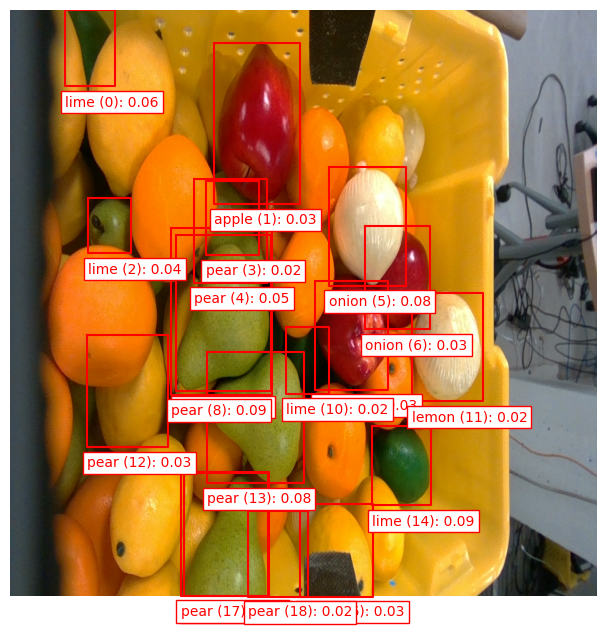

In [13]:
# take RealSense picture and run OWL-ViT inference
pcd,rgbdImage = rsc.getPCD()
img_tensor = torch.tensor(np.asarray(rgbdImage.color), dtype=torch.float32)
img = np.asarray(rgbdImage.color)

# run image through OWL-ViT
texts = ["a photo of an apple", "a photo of a lemon", "a photo of a lime", "a photo of a pear", "a photo of a onion"]
# texts = [ "a photo of red cube", "a photo of a blue cube", "a photo of a yellow cube"]
# texts = ["apple", "lemon", "lime", "pear"]
# texts = ["a photo of a pear"]
inputs = processor(texts, images=img_tensor, padding=True, return_tensors="pt")
outputs = model(**inputs)
target_sizes = torch.Tensor([img.shape[:2][::-1]])

# Get prediction logits
def get_preds(outputs):
    logits = torch.max(outputs["logits"][0], dim=-1)
    scores = torch.sigmoid(logits.values).cpu().detach().numpy()
    # Get prediction labels and boundary boxes
    labels = logits.indices.cpu().detach().numpy()
    # boxes = outputs["pred_boxes"][0].cpu().detach().numpy()
    boxes = outputs["pred_boxes"][0].cpu().detach().numpy()
    pboxes = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.01)[0]['boxes']
    return scores, labels, boxes, pboxes

scores, labels, boxes, pboxes = get_preds(outputs)
input_image = np.asarray(img).astype(np.float32) / 255.0
text_queries = ["apple", "lemon", "lime", "pear", "onion"]
# text_queries = ["pear"]
# text_queries = ["r", "b", "y"]
# text_queries = ["apple", "lemon", "lime", "pear"]
THRESHOLD = 0.02
plot_predictions(input_image, text_queries, scores, boxes, labels, score_threshold=THRESHOLD)
bboxes, uboxes = get_boxes(input_image, text_queries, scores, boxes, labels, score_threshold=THRESHOLD)


In [14]:
pcd,rgbdImage = rsc.getPCD()
# index corresponds to (<num>) following label name of bounding boxes in above annotated image
index = 3
dm, rm, imgm = retrieve_mask_from_image_crop(bboxes[index][0], rgbdImage)
cpcd, mc = crop_and_denoise_pcd(dm, rgbdImage)
grasp_pose = [mc[0][1], -mc[0][0], mc[0][2]]
print(grasp_pose)
displayWorld(cpcd)

[-0.049679418688263366, 0.07258206822028672, 0.31279537732774404]


In [15]:
pcaFrame, tmat = get_pca_frame(mc[0], mc[1], scale=1500.0)
# pcaFrame, tmat = get_pca_frame_quat(mc[0], mc[1], scale=1500.0)
# tmat[:3, 3] = grasp_pose
tmat[:3, 3] = [0,0,0]
tmat

modified indices: [0 0 1]
modified indices: [2 0 1]
[[0.22311912 0.         0.         0.        ]
 [0.         0.54242542 0.         0.        ]
 [0.         0.         0.12003556 0.        ]
 [0.         0.         0.         1.        ]]
[[-0.95241608  0.29976558  0.05517434 -0.07258207]
 [-0.24315792 -0.85639641  0.45547713 -0.04967942]
 [ 0.18378748  0.42038767  0.88853608  0.31279538]
 [ 0.          0.          0.          1.        ]]
[[-0.21250224  0.16260047  0.00662288 -0.07258207]
 [-0.05425318 -0.46453118  0.05467345 -0.04967942]
 [ 0.0410065   0.22802896  0.10665593  0.31279538]
 [ 0.          0.          0.          1.        ]]
TriangleMesh with 1134 points and 2240 triangles.


array([[-0.95241608,  0.29976558,  0.05517434,  0.        ],
       [-0.24315792, -0.85639641,  0.45547713,  0.        ],
       [ 0.18378748,  0.42038767,  0.88853608,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [16]:
worldFrame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.075, origin=[0, 0, 0])

geometries = [cpcd, pcaFrame, worldFrame]
# geometries = [cpcd, *get_pca_mesh(mc[0], mc[1]), worldFrame]
# Visualize the scene
o3d.visualization.draw_geometries(geometries)

In [17]:
# get masks from bounding boxes
pcd,rgbdImage = rsc.getPCD()

dims = target_sizes[0].numpy().astype(dtype=int)
boxes = np.array([np.array(i[0]) for i in bboxes])
H, W = dims[1], dims[0]
boxes = torch.tensor(boxes)
labels = np.array([i[1] for i in uboxes])
size = [H, W]
pred_dict = {
    # "boxes": normalized_boxes,
    "boxes": boxes,
    "size": [size[1], size[0]], # H, W
    "labels": labels
}

rgb_array = (np.array(rgbdImage.color))
# don't know why colors aren't correct without this prior manual rotation
cv2_array = rgb_array[:, :, ::-1].copy()
image = cv2.cvtColor(cv2_array, cv2.COLOR_RGB2BGR)


In [18]:
# TODO: figure out why this takes so long
# ok I immediately see now that this calculates the image embeddings...
predictor.set_image(image)

In [19]:
boxes_copy = copy.deepcopy(boxes)
transformed_boxes = predictor.transform.apply_boxes_torch(boxes_copy, img.shape[:2][::-1])

masks, _, _ = predictor.predict_torch(
    point_coords = None,
    point_labels = None,
    boxes = transformed_boxes,
    multimask_output = False,
)

(-0.5, 1279.5, 719.5, -0.5)

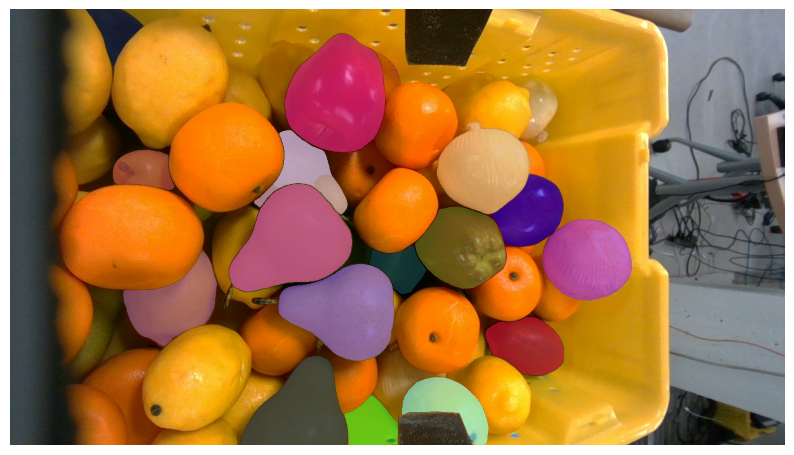

In [20]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
plt.axis('off')

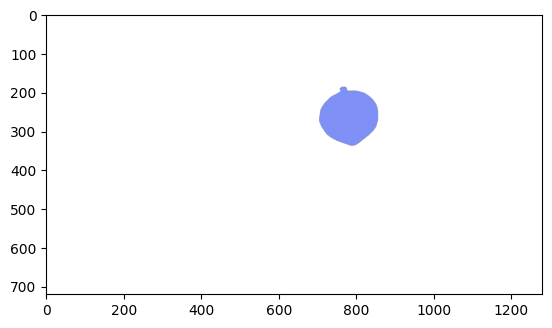

In [39]:
index = 5
show_mask(masks[index].cpu().numpy(), plt.gca(), random_color=True)

In [40]:
pcd,rgbdImage = rsc.getPCD()
mdm = create_depth_mask_from_mask(np.array(masks[index][0]), rgbdImage.depth)
mcpcd, mmc = crop_and_denoise_pcd(mdm, rgbdImage, NB=5)
m_grasp_pose = [mmc[0][1], -mmc[0][0], mmc[0][2]]
print(m_grasp_pose)
# displayWorld(mcpcd)

[-0.04747816659270684, -0.07964675025889667, 0.32338141823704597]


In [41]:
worldFrame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.075, origin=[0, 0, 0])

pcaFrame, tmat = get_pca_frame(mmc[0], mmc[1], scale=2000.0)
# pcaFrame, tmat = get_pca_frame_quat(mmc[0], mmc[1], scale=2000.0)
geometries = [mcpcd, pcaFrame, worldFrame]
# geometries = [mcpcd, *getPrincipalAxes(mmc[0], mmc[1]), worldFrame]
# Visualize the scene
o3d.visualization.draw_geometries(geometries)

modified indices: [0 0 1]
modified indices: [2 0 1]
[[0.48467196 0.         0.         0.        ]
 [0.         0.13147423 0.         0.        ]
 [0.         0.         0.52559711 0.        ]
 [0.         0.         0.         1.        ]]
[[-0.81726729  0.57194311  0.07039362  0.07964675]
 [-0.57121578 -0.78792257 -0.22997946 -0.04747817]
 [-0.07607045 -0.22816464  0.97064627  0.32338142]
 [ 0.          0.          0.          1.        ]]
[[-0.39610654  0.07519578  0.03699868  0.07964675]
 [-0.27685227 -0.10359151 -0.12087654 -0.04747817]
 [-0.03686921 -0.02999777  0.51016887  0.32338142]
 [ 0.          0.          0.          1.        ]]
TriangleMesh with 1134 points and 2240 triangles.


In [42]:
tmat

array([[-0.81726729,  0.57194311,  0.07039362,  0.07964675],
       [-0.57121578, -0.78792257, -0.22997946, -0.04747817],
       [-0.07607045, -0.22816464,  0.97064627,  0.32338142],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [43]:
m_grasp_pose

[-0.04747816659270684, -0.07964675025889667, 0.32338141823704597]